In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time;  from datetime import datetime
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
nyc = pd.read_csv('gapi_city_data-export-2017-11-30.csv') # read the gapi database
nyc.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
nyc.drop("Organic Searches", axis=1,inplace=True) # Drops Column
nyc = nyc.loc[nyc['City'] == 1023191] # Selects records only NYC

In [3]:
weather = pd.read_csv('open_weather_6cities.csv')  # read the weather database
weather.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
weather = weather.loc[weather['city_id'] == 5128581] # Selects records only NYC

In [20]:
#Join tables on Unix Time


# takes a string  in YYYMMDDHH (nyc(Date Hour)) and returns a Unix Time assuming local time zone for input
# this works because (local time on my machine) == (timezone of ga: time{set by ga account preferences}) 
def unixtimestamp(row):
    return int(int(time.mktime(datetime.strptime(row, "%Y%m%d%H").timetuple())))

# creates new column unix_time in nyc using unixtimestamp
nyc['unix_time'] = nyc.apply(lambda row: unixtimestamp(str(row['Date Hour'])), axis=1)

# join nyc to weather on unix_time 
df = nyc.join(weather.set_index('dt'), on='unix_time') 

# fix to drop rows where no weather data
df = df.dropna(subset=['temp'])

In [21]:
df2= df[["User Type",'Device Category','Sessions','Transactions', 'Revenue Per User','temp','weather_id']]

In [24]:
df2.head()

,User Type,Device Category,Sessions,Transactions,Revenue Per User,temp,weather_id
5882,New Visitor,mobile,3,0,0.0,295.07,701.0
5883,New Visitor,desklet,1,0,0.0,295.07,701.0
5884,Returning Visitor,mobile,1,0,0.0,295.07,701.0
5885,New Visitor,mobile,5,0,0.0,294.84,701.0
5886,Returning Visitor,desklet,1,0,0.0,294.84,701.0


In [23]:
df2.loc[:,('Device Category')] = df2.loc[:,('Device Category')].replace(to_replace=['desktop','tablet'],value='desklet')


/home/dj/programming/data_env/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [86]:
df.loc[:,('Device Category')].head()

5882     mobile
5883    desklet
5884     mobile
5885     mobile
5886    desklet
Name: Device Category, dtype: object

In [39]:
def return_first_digit(row): # takes an int, returns first character as a string
    return (str(row)[0])
# remove all but the first unit of weather_id int
df2['weather_id'] = df2.loc[:,('weather_id')].apply(return_first_digit)

In [40]:
df3 = df2.drop(['Sessions','Transactions'],axis=1)

In [41]:
weather_id_dict = {'2':'2 Thunderstorms','3':'3 Drizzle','5':'5 Rain','6':'6 Snow','7':'7 Atmosphere','8':'8 Clear','9':'9 Extreme'}

In [42]:
df3 = df3.replace({'weather_id':weather_id_dict}) 

In [43]:
df4 = df3.pivot_table(index='User Type', columns='weather_id',values='Revenue Per User', aggfunc=np.average)

In [44]:
df4

weather_id,2 Thunderstorms,3 Drizzle,5 Rain,6 Snow,7 Atmosphere,8 Clear
User Type,,,,,,
New Visitor,0.94372,1.161716,0.864628,1.004668,0.781226,0.886482


In [45]:
#df4=df4[df4.iloc[-1,:].sort_values(ascending=False).index]


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

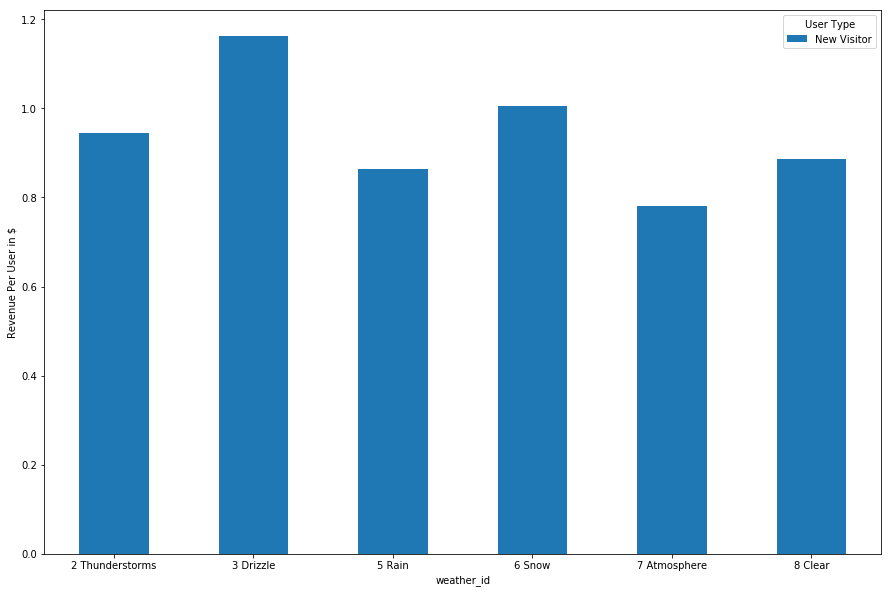

In [46]:
# Average Revenue per customer 
d = df4.transpose().plot.bar()
plt.ylabel('Revenue Per User in $')
plt.xticks(rotation='horizontal')



## Weather ID / Revenue per User Graph

#### This graph is for New York City, with Revenue Per User graphed against weather category from Open Weather Maps.  

Catergory 2, which is the umbrella category for thunderstorms, has the highest Ave. Revenue for returning customers.

What is curious is that Drizzle (Cat 3) has higher revenue than rain (Cat 4) I think it would be worth exploring how many of the rain category was light rain, before I stripped the trailing two digits that provides more detail about the kind of rain. It might make sense to move light rain to the drizzle bucket, and put more serious rain events (freezing, heavy, extreme rain) into the thunderstoms bucket, and see if there is further divergence.

There were also sometimes more than one weather classification in the weather table. Should examine those and see if they are expressed in a particular order (I took only the first one) and if we harvest value from both those values.

Once we remedy that and have some data that we think is accurate, we can do a 2 std. dev. above and below average and see if it might make sense to bid more during extreme weather
